In [3]:
import os, glob
import numpy as np
import json
import random
import rasterio
import pickle
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from rasterio.windows import Window
import matplotlib.pyplot as plt


# Data Loading

Total TIFF files found: 36053
Sample file paths:
SEN12FLOOD\new.tif
SEN12FLOOD\0\S1A_IW_GRDH_1SDV_20190206T030905_20190206T030930_025803_02DEB0_2CC8_corrected_VH.tif
SEN12FLOOD\0\S1A_IW_GRDH_1SDV_20190206T030905_20190206T030930_025803_02DEB0_2CC8_corrected_VV.tif
SEN12FLOOD\0\S1A_IW_GRDH_1SDV_20190218T030905_20190218T030930_025978_02E4EB_98B8_corrected_VH.tif
SEN12FLOOD\0\S1A_IW_GRDH_1SDV_20190218T030905_20190218T030930_025978_02E4EB_98B8_corrected_VV.tif


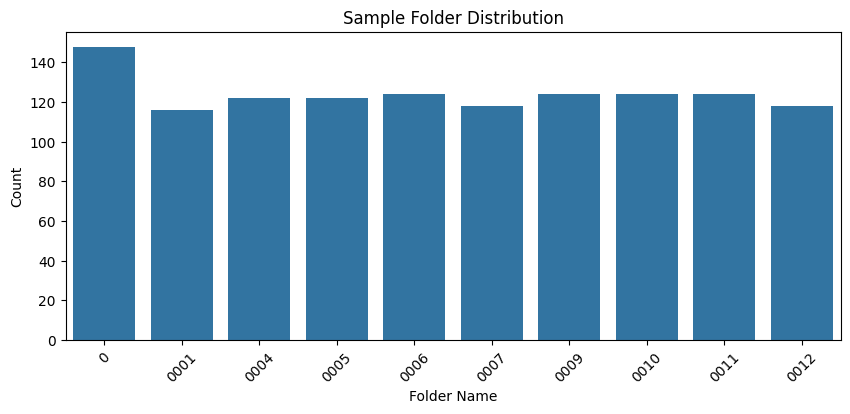

In [4]:
# Define dataset directory (adjust as needed)
data_dir = "SEN12FLOOD"

# List all TIFF files recursively
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print a sample of file paths to see the diversity (they may include Sentinel-1 and Sentinel-2 files)
print("Sample file paths:")
for f in tif_files[:5]:
    print(f)

# Optionally, plot a histogram of folder names to see the sensor or region distribution
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = collections.Counter(folder_names)

# Convert folder_counts (a Counter) into a DataFrame
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"])

# Sort by folder name or count if desired (here we just show the first 10 sorted by folder name)
df_folder_counts = df_folder_counts.sort_values("Folder").head(10)

plt.figure(figsize=(10, 4))
sns.barplot(data=df_folder_counts, x="Folder", y="Count")
plt.title("Sample Folder Distribution")
plt.xlabel("Folder Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [5]:
# Load JSON files for metadata (adjust paths if needed)
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

with open(s1_json_path, "r") as f:
    s1_data = json.load(f)
with open(s2_json_path, "r") as f:
    s2_data = json.load(f)

# Build label mapping from folder names to flood labels
flood_labels = {}
# Example logic for Sentinel-1 data (adjust based on actual JSON structure)
for folder, details in s1_data.items():
    flood_status = any(
        entry.get("FLOODING", False)
        for key, entry in details.items() 
        if isinstance(entry, dict) and "FLOODING" in entry
    )
    flood_labels[folder] = int(flood_status)

# Update mapping using Sentinel-2 data if applicable
for folder, details in s2_data.items():
    flood_status = any(
        entry.get("FLOODING", False)
        for key, entry in details.items() 
        if isinstance(entry, dict) and "FLOODING" in entry
    )
    flood_labels[folder] = int(flood_status)

# Verify mapping
print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]:
    print(f"Folder: {folder}, Flooding: {label}")

# Check overall label distribution in the dataset using folder names from TIFF files
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
print("Label Distribution in Dataset:", collections.Counter(mapped_labels))

Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Label Distribution in Dataset: Counter({1: 24333, 0: 11720})


Sensor distribution:
sensor
Sentinel-2    26844
Sentinel-1     9208
Other             1
Name: count, dtype: int64


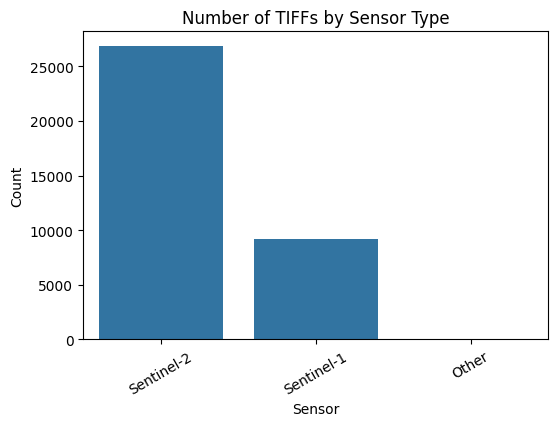

In [6]:
# Classify each TIFF by sensor type based on its path or filename
sensor_types = []
for path in tif_files:
    fname = os.path.basename(path)
    if "/S1" in path or fname.startswith("S1"):
        sensor_types.append("Sentinel-1")
    elif "/S2" in path or fname.startswith("S2"):
        sensor_types.append("Sentinel-2")
    else:
        sensor_types.append("Other")

# Build a DataFrame and count
df_sensors = pd.DataFrame({"path": tif_files, "sensor": sensor_types})
counts = df_sensors["sensor"].value_counts()

print("Sensor distribution:")
print(counts)

# Bar plot for visual inspection
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Number of TIFFs by Sensor Type")
plt.ylabel("Count")
plt.xlabel("Sensor")
plt.xticks(rotation=30)
plt.show()


In [7]:
# We already have `tif_files` and `sensor_types` from before, but let's rebuild succinctly:
sensor_classification = []
for path in tif_files:
    if "/S1" in path or os.path.basename(path).startswith("S1"):
        sensor_classification.append("Sentinel-1")
    elif "/S2" in path or os.path.basename(path).startswith("S2"):
        sensor_classification.append("Sentinel-2")
    else:
        sensor_classification.append("Other")

df_sensors = pd.DataFrame({
    "filepath": tif_files,
    "sensor": sensor_classification
})

# Split into lists
sentinel1_files = df_sensors[df_sensors.sensor == "Sentinel-1"]["filepath"].tolist()
sentinel2_files = df_sensors[df_sensors.sensor == "Sentinel-2"]["filepath"].tolist()
other_files     = df_sensors[df_sensors.sensor == "Other"]["filepath"].tolist()

print(f"Sentinel‑1 count: {len(sentinel1_files)}")
print(f"Sentinel‑2 count: {len(sentinel2_files)}")
print(f"Other count:      {len(other_files)}")


Sentinel‑1 count: 9208
Sentinel‑2 count: 26844
Other count:      1


In [8]:
import os

# Build mapping: { folder_id : {band: filepath, ...}, ... }
s2_folder_groups = {}
for f in sentinel2_files:
    folder = os.path.basename(os.path.dirname(f))   # e.g. "0004"
    fname = os.path.basename(f)

    # Extract band ID from filename (e.g., "S2B04.tif" -> "04")
    if "B" in fname:
        band = fname.split("B")[-1][:2]
    else:
        band = "??"  # fallback

    if folder not in s2_folder_groups:
        s2_folder_groups[folder] = {}
    s2_folder_groups[folder][band] = f


In [9]:
import rasterio
import numpy as np

def load_s2_true_color_stretched(prefix: str, band_map=None, pmin=2, pmax=98):
    """
    Given a prefix (folder) for Sentinel-2 single-band TIFFs, read bands 04,03,02,
    then apply a per-channel percentile stretch (default 2–98%) and return an
    8-bit RGB image.

    Parameters
    ----------
    prefix   : str
      The folder name (e.g. '0111') or any key into your s2_folder_groups dict.
    band_map : dict, optional
      Maps 'R','G','B' to band strings (default {'R':'04','G':'03','B':'02'}).
    pmin, pmax : float
      Percentiles for lower/upper clip.

    Returns
    -------
    np.ndarray
      uint8 RGB image of shape (H, W, 3).
    """
    if band_map is None:
        band_map = {'R':'04','G':'03','B':'02'}

    grp = s2_folder_groups[prefix]
    chans = {}
    for col, b in band_map.items():
        with rasterio.open(grp[b]) as src:
            chans[col] = src.read(1).astype(float)

    # Build the 3‐channel array
    arr = np.stack([chans['R'], chans['G'], chans['B']], axis=-1)

    # Per‐channel percentile stretch
    out = np.zeros_like(arr)
    for i, col in enumerate(['R','G','B']):
        band = arr[..., i]
        lo, hi = np.percentile(band, (pmin, pmax))
        band = np.clip(band, lo, hi)
        out[..., i] = ( (band - lo) / (hi - lo) * 255 )

    return out.astype(np.uint8)


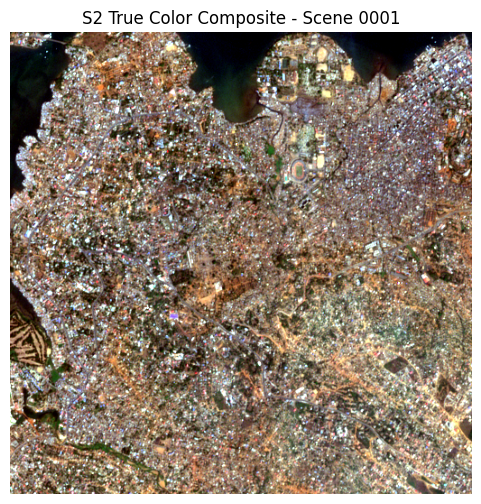

In [10]:
import matplotlib.pyplot as plt

folder_id = list(s2_folder_groups.keys())[1]  # pick first available scene
rgb_img = load_s2_true_color_stretched(folder_id)

plt.figure(figsize=(6,6))
plt.imshow(rgb_img)
plt.title(f"S2 True Color Composite - Scene {folder_id}")
plt.axis("off")
plt.show()


In [11]:
def load_s1_grayscale(folder_id: str, pmin=2, pmax=98):
    """
    Load Sentinel-1 SAR grayscale image from a folder.
    Applies percentile stretch for contrast.

    Parameters
    ----------
    folder_id : str
        The scene folder (e.g., '0004').
    pmin, pmax : float
        Percentiles for contrast stretch.

    Returns
    -------
    np.ndarray
        uint8 grayscale image (H, W).
    """
    # Find the SAR file for this folder
    s1_files = [f for f in sentinel1_files if os.path.basename(os.path.dirname(f)) == folder_id]
    if len(s1_files) == 0:
        raise ValueError(f"No Sentinel-1 file found for folder {folder_id}")

    with rasterio.open(s1_files[0]) as src:
        band = src.read(1).astype(float)

    lo, hi = np.percentile(band, (pmin, pmax))
    band = np.clip(band, lo, hi)
    out = (band - lo) / (hi - lo) * 255

    return out.astype(np.uint8)


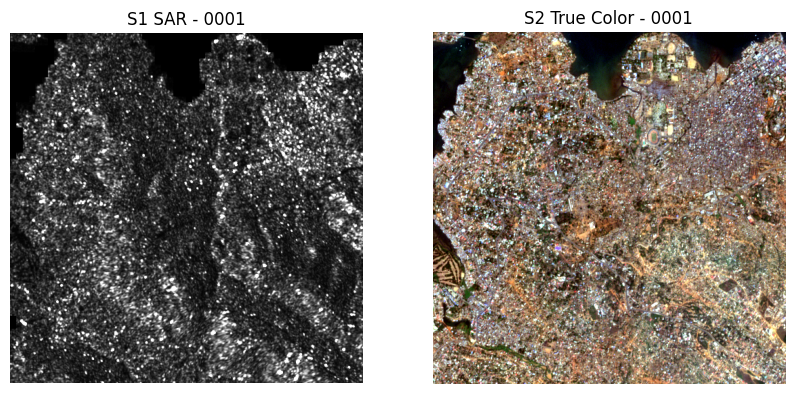

In [12]:
folder_id = list(s2_folder_groups.keys())[1]  # pick one scene

s1_img = load_s1_grayscale(folder_id)
s2_img = load_s2_true_color_stretched(folder_id)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(s1_img, cmap="gray")
plt.title(f"S1 SAR - {folder_id}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(s2_img)
plt.title(f"S2 True Color - {folder_id}")
plt.axis("off")
plt.show()


# Pre Processing


In [13]:
import os, numpy as np, rasterio, cv2
import findpeaks

In [14]:
def normalize_0_1(arr, eps=1e-8):
    """Scale array to [0,1]."""
    arr = arr.astype(np.float32)
    mn, mx = np.min(arr), np.max(arr)
    return (arr - mn) / (mx - mn + eps)

In [15]:
def resize_hw(arr, out_h, out_w, is_mask=False):
    """Resize 2D/3D arrays to target size."""
    interp = cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR
    if arr.ndim == 2:
        return cv2.resize(arr, (out_w, out_h), interpolation=interp)
    elif arr.ndim == 3:
        return cv2.resize(arr, (out_w, out_h), interpolation=interp)
    else:
        raise ValueError("arr must be 2D or 3D (H,W[,C])")

In [16]:
from scipy.ndimage import uniform_filter, variance
def lee_filter(img, size):
    """Apply Lee filter to suppress speckle noise in SAR image."""
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    # overall_variance = variance(img)
    cu=0.25
    noise_variance = (cu * img_mean)**2
    # Lee weights
    #img_weights = img_variance / (img_variance + overall_variance+ 1e-8)
    img_weights = 1 - (noise_variance / (img_variance + 1e-8))
    # Final output
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output


In [17]:
def load_s1_image(folder_id, win_size=15, pmin=2, pmax=98, use_log=False):
    """
    Loads first S1 band in folder, applies custom Lee filter + percentile stretch,
    returns float [0,1], shape (H,W,1).
    """
    s1_files = [f for f in sentinel1_files if os.path.basename(os.path.dirname(f)) == folder_id]
    if len(s1_files) == 0:
        raise ValueError(f"No Sentinel-1 file found for folder {folder_id}")

    with rasterio.open(s1_files[0]) as src:
        band = src.read(1).astype(np.float32)

    # Apply custom Lee filter
    band_lee = lee_filter(band, size=win_size)

    if use_log:
        band_lee = np.log1p(band_lee)

    # # Percentile stretch
    # lo, hi = np.percentile(band_lee, (pmin, pmax))
    # band_lee = np.clip(band_lee, lo, hi)

    # # Normalize to [0,1]
    # band_norm = (band_lee - lo) / (hi - lo + 1e-8)

    # return band_norm[..., None].astype(np.float32)
    valid_pixels = band_lee[band_lee > 0]
    if valid_pixels.size > 0:
        lo, hi = np.percentile(valid_pixels, (pmin, pmax))
    else:
        lo, hi = 0, 1

    # 4. CORRECT ORDER: Rescale first based on percentiles
    band_norm = (band_lee - lo) / (hi - lo + 1e-8)

    # 5. Clip the FINAL result to the display range [0, 1]
    band_norm = np.clip(band_norm, 0, 1)

    return band_norm[..., None].astype(np.float32)

In [18]:
def load_s2_image(folder_id, band_map=None, pmin=2, pmax=98):
    """
    Returns float image in [0,1].
    If bands 04/03/02 exist -> (H,W,3). Else -> (H,W,1) from any available band.
    """
    if band_map is None:
        band_map = {'R':'04','G':'03','B':'02'}

    if folder_id in s2_folder_groups:
        grp = s2_folder_groups[folder_id]
        have_rgb = all(b in grp for b in band_map.values())
        if have_rgb:
            chans = []
            for b in ['R','G','B']:
                with rasterio.open(grp[band_map[b]]) as src:
                    band = src.read(1).astype(np.float32)
                lo, hi = np.percentile(band, (pmin, pmax))
                band = np.clip(band, lo, hi)
                chans.append(normalize_0_1(band))
            s2 = np.stack(chans, axis=-1)  # (H,W,3)
            return s2
        else:
            # fallback: single band
            any_path = next(iter(grp.values()))
            with rasterio.open(any_path) as src:
                band = src.read(1).astype(np.float32)
            return normalize_0_1(band)[..., None]

    # fallback: if no grouped entry found
    s2_files = [f for f in sentinel2_files if os.path.basename(os.path.dirname(f)) == folder_id]
    if len(s2_files) == 0:
        raise ValueError(f"No S2 file found for folder {folder_id}")
    with rasterio.open(s2_files[0]) as src:
        band = src.read(1).astype(np.float32)
    return normalize_0_1(band)[..., None]

In [19]:
TARGET_H, TARGET_W = 256, 256

def preprocess_scene(folder_id, target_hw=(TARGET_H, TARGET_W), use_log=False): # Add use_log here
    """
    Returns dict with:
      - s1 : (H,W,1) preprocessed SAR
      - s2 : (H,W,C) preprocessed optical (3 or 1 channel)
    """
    s1 = load_s1_image(folder_id, use_log=True) # Pass it to load_s1_image
    s2 = load_s2_image(folder_id)

    s1r = resize_hw(s1, target_hw[0], target_hw[1]).astype(np.float32)
    s2r = resize_hw(s2, target_hw[0], target_hw[1]).astype(np.float32)

    return {"s1": s1r, "s2": s2r}

S1 shape: (256, 256) min/max: 0.0 1.0
S2 shape: (256, 256, 3) min/max: 0.0 1.0


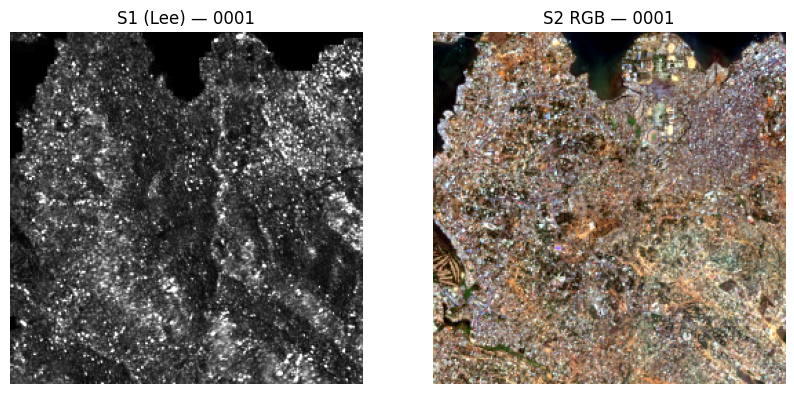

In [20]:
import matplotlib.pyplot as plt

test_folder = list(s2_folder_groups.keys())[1]  # pick one scene
sample = preprocess_scene(test_folder, use_log=True)

s1r, s2r = sample["s1"], sample["s2"]
print("S1 shape:", s1r.shape, "min/max:", s1r.min(), s1r.max())
print("S2 shape:", s2r.shape, "min/max:", s2r.min(), s2r.max())

# For S1 (single channel), make sure it's (H,W)
if s1r.ndim == 3 and s1r.shape[-1] == 1:
    s1_show = s1r[..., 0]   # drop channel dim
elif s1r.ndim == 2:
    s1_show = s1r
else:
    raise ValueError(f"Unexpected S1 shape: {s1r.shape}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(s1_show, cmap="gray")
plt.title(f"S1 (Lee) — {test_folder}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(s2r)  # should already be (H,W,3) RGB
plt.title(f"S2 RGB — {test_folder}")
plt.axis("off")
plt.show()



# Quantum Image Fusion


In [21]:
import pennylane as qml
from pennylane import numpy as pnp


In [22]:
import numpy as np

def random_unitary_numpy(dim, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Ginibre ensemble method: random complex Gaussian
    X = (np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)) / np.sqrt(2.0)
    # QR decomposition
    Q, R = np.linalg.qr(X)
    # Make it unitary (fix phases on diagonal of R)
    d = np.diagonal(R)
    ph = d / np.abs(d)
    Q = Q * ph
    return Q.astype(np.complex128)


In [23]:
# generate a random unitary
dim = 16   # for 4 qubits
U = random_unitary_numpy(dim, seed=42)

# check its shape
print("Shape:", U.shape)   # should be (16,16)

# check unitarity
I = np.eye(dim)
UdagU = U.conj().T @ U

error = np.linalg.norm(UdagU - I)
print("‖U†U - I‖ =", error)


Shape: (16, 16)
‖U†U - I‖ = 3.1439855568747655e-15


In [24]:
n_qubits = 4  # Number of qubits
dev = qml.device("default.qubit", wires=n_qubits)

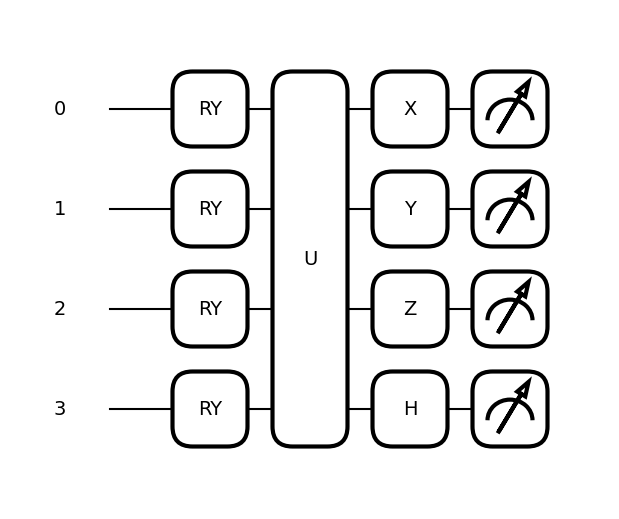

In [25]:
# fix a Haar-random unitary once (saved model idea from the paper)
_HAAR_U = random_unitary_numpy(2**n_qubits, seed=42).astype(np.complex128)

@qml.qnode(dev)
def _qif_circuit(theta):
    """
    theta: array-like of length 4, each in [0, pi]
    returns: 4 Z-expectations (one per qubit)
    """
    # 1) encoding with RY gates
    for w in range(n_qubits):
        qml.RY(theta[w], wires=w)

    # 2) fixed random unitary (Haar)
    qml.QubitUnitary(_HAAR_U, wires=[0,1,2,3])

    # 3) feature extraction gates (X,Y,Z,H)
    gates = [qml.PauliX, qml.PauliY, qml.PauliZ, qml.Hadamard]
    for w, gate in enumerate(gates):
        gate(wires=w)

    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

import matplotlib.pyplot as plt

theta = np.random.rand(n_qubits) * np.pi

# text-based circuit
#print(qml.draw(_qif_circuit)(theta))

# matplotlib circuit diagram
fig, ax = qml.draw_mpl(_qif_circuit)(theta)
plt.show()


In [26]:
def _encode_block_4x4_to_4_angles(block4x4: np.ndarray):
    """
    Map a 4x4 SAR block -> four values via 2x2 average pooling,
    then scale to angles in [0, pi].
    """
    # split 4x4 into 2x2 tiles: TL, TR, BL, BR
    TL = block4x4[0:2, 0:2].mean()
    TR = block4x4[0:2, 2:4].mean()
    BL = block4x4[2:4, 0:2].mean()
    BR = block4x4[2:4, 2:4].mean()
    # input SAR is in [0,1]; map to [0, pi]
    return pnp.array([TL, TR, BL, BR]) * pnp.pi

In [27]:
def quantum_process_sar_to_64x64(s1_256x256: np.ndarray) -> np.ndarray:
    """
    s1_256x256: SAR preprocessed image (H,W,1) in [0,1] with H=W=256
    returns: (64,64) quantum-processed SAR channel in [0,1]
    """
    if s1_256x256.ndim == 3 and s1_256x256.shape[-1] == 1:
        s1 = s1_256x256[..., 0]
    elif s1_256x256.ndim == 2:
        s1 = s1_256x256
    else:
        raise ValueError(f"Expected (256,256,1) or (256,256); got {s1_256x256.shape}")

    H, W = s1.shape
    assert H == 256 and W == 256, "Provide 256x256 SAR to get 64x64 output"

    out = np.zeros((64, 64), dtype=np.float32)
    for oy in range(64):
        for ox in range(64):
            y0, x0 = oy*4, ox*4
            block = s1[y0:y0+4, x0:x0+4]
            theta = _encode_block_4x4_to_4_angles(block)
            z_exps = _qif_circuit(theta)  # returns 4 values in [-1,1]
            # collapse to a single scalar for the block; mean works well
            s_val = float(pnp.mean(pnp.array(z_exps)))
            # map [-1,1] -> [0,1]
            out[oy, ox] = (s_val + 1.0) * 0.5
    return out

In [28]:
def Quantum_fuse_method_ii(rgb_256x256: np.ndarray, S_64x64: np.ndarray) -> np.ndarray:
    """
    Method II: (S+3*R)/4, etc. (paper's eqns 5–7)
    Expects RGB in [0,1] (256x256x3). Upsample S to match 256 for display parity,
    or downsample RGB to 64x64 depending on your training setup.
    Here: downsample RGB to 64x64 to match the paper's 64x64 training size.
    """
    R64 = cv2.resize(rgb_256x256[...,0], (64,64), interpolation=cv2.INTER_AREA)
    G64 = cv2.resize(rgb_256x256[...,1], (64,64), interpolation=cv2.INTER_AREA)
    B64 = cv2.resize(rgb_256x256[...,2], (64,64), interpolation=cv2.INTER_AREA)

    Rn = (S_64x64 + 3.0*R64)/4.0
    Gn = (S_64x64 + 3.0*G64)/4.0
    Bn = (S_64x64 + 3.0*B64)/4.0
    fused = np.stack([Rn, Gn, Bn], axis=-1)
    return np.clip(fused, 0.0, 1.0).astype(np.float32)

In [29]:
def Quantum_fuse_method_iii(rgb_256x256: np.ndarray, S_64x64: np.ndarray) -> np.ndarray:
    """
    Method III: (S+R+G+B)/4
    """
    R64 = cv2.resize(rgb_256x256[...,0], (64,64), interpolation=cv2.INTER_AREA)
    G64 = cv2.resize(rgb_256x256[...,1], (64,64), interpolation=cv2.INTER_AREA)
    B64 = cv2.resize(rgb_256x256[...,2], (64,64), interpolation=cv2.INTER_AREA)

    fused_scalar = (S_64x64 + R64 + G64 + B64)/4.0
    # replicate to 3 channels so it can go into standard CNNs expecting 3ch
    fused = np.repeat(fused_scalar[..., None], 3, axis=-1)
    return np.clip(fused, 0.0, 1.0).astype(np.float32)

Quantum SAR (64x64) min/max: 0.34102982 0.6348836
Fused (Method II) shape: (64, 64, 3) min/max: 0.13246673 0.83795017
Fused (Method III) shape: (64, 64, 3) min/max: 0.13265301 0.7773868


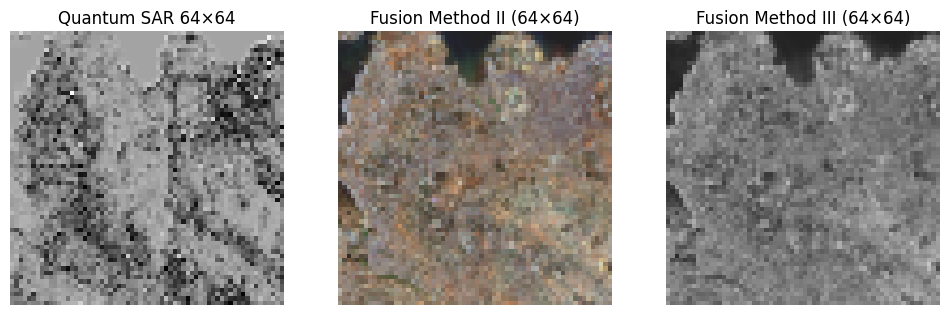

In [30]:
# --- Quantum process + fuse ---
# quantum SAR -> 64x64
S_q_64 = quantum_process_sar_to_64x64(s1r)  # s1r from your preprocess_scene

# pick a fusion method from the paper:
Quantum_fused_m2_64 = Quantum_fuse_method_ii(s2r, S_q_64)   # -> (64,64,3)
Quantum_fused_m3_64 = Quantum_fuse_method_iii(s2r, S_q_64)  # -> (64,64,3)

print("Quantum SAR (64x64) min/max:", S_q_64.min(), S_q_64.max())
print("Fused (Method II) shape:", Quantum_fused_m2_64.shape, "min/max:", Quantum_fused_m2_64.min(), Quantum_fused_m2_64.max())
print("Fused (Method III) shape:", Quantum_fused_m3_64.shape, "min/max:", Quantum_fused_m3_64.min(), Quantum_fused_m3_64.max())

# visualize
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(S_q_64, cmap="gray"); plt.title("Quantum SAR 64×64"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(Quantum_fused_m2_64); plt.title("Fusion Method II (64×64)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(Quantum_fused_m3_64); plt.title("Fusion Method III (64×64)"); plt.axis("off")
plt.show()


In [31]:
import numpy as np, cv2

# 1) Haar unitary shape + unitarity check
assert _HAAR_U.shape == (2**n_qubits, 2**n_qubits)
uh_err = np.linalg.norm(_HAAR_U.conj().T @ _HAAR_U - np.eye(2**n_qubits))
print("U^H U - I norm:", uh_err)
assert uh_err < 1e-5, "Haar unitary is not numerically unitary (increase precision or re-sample)."

# 2) QNode basic shape and value bounds
theta_test = np.random.rand(n_qubits) * np.pi
out = _qif_circuit(theta_test)
print("qnode out:", out)
assert len(out) == n_qubits
assert np.all(np.abs(np.array(out)) <= 1.0 + 1e-9)

# 3) Determinism with fixed Haar (same theta twice)
o1 = _qif_circuit(theta_test)
o2 = _qif_circuit(theta_test)
assert np.allclose(o1, o2, atol=1e-9), "QNode outputs not deterministic for same theta (unexpected)."

# 4) Block encoder mapping correctness
blk = np.ones((4,4), dtype=np.float32) * 0.5
angles = _encode_block_4x4_to_4_angles(blk)
print("angles:", angles)
assert angles.shape == (4,)
assert np.all((angles >= 0) & (angles <= np.pi))

# 5) 256->64 coverage + value range
dummy_sar = np.random.rand(256,256).astype(np.float32)
S64 = quantum_process_sar_to_64x64(dummy_sar)
print("S64 stats:", S64.min(), S64.max(), S64.shape)
assert S64.shape == (64,64)
assert np.all((S64 >= 0) & (S64 <= 1))

# 6) Fusion outputs shape & ranges
dummy_rgb = np.random.rand(256,256,3).astype(np.float32)
f2 = Quantum_fuse_method_ii(dummy_rgb, S64)
f3 = Quantum_fuse_method_iii(dummy_rgb, S64)
print("f2 shape/range:", f2.shape, f2.min(), f2.max())
print("f3 shape/range:", f3.shape, f3.min(), f3.max())
assert f2.shape == (64,64,3) and f3.shape == (64,64,3)
assert np.all((f2 >= 0) & (f2 <= 1)) and np.all((f3 >= 0) & (f3 <= 1))


U^H U - I norm: 3.1439855568747655e-15
qnode out: [np.float64(-0.12090292235730937), np.float64(0.19350101056061914), np.float64(-0.2410607910561931), np.float64(0.006850488030794466)]
angles: [1.57079637 1.57079637 1.57079637 1.57079637]
S64 stats: 0.33562636 0.59514624 (64, 64)
f2 shape/range: (64, 64, 3) 0.22146466 0.6824156
f3 shape/range: (64, 64, 3) 0.3802704 0.5977333


# Classical Image Fusion

In [32]:
import numpy as np

def fuse_method_i(rgb, sar):
    """Naïve average fusion with downsampling to 64x64."""
    sar_exp = np.repeat(sar[..., None], 3, axis=-1)
    fused = (rgb + sar_exp) / 2.0
    fused = np.clip(fused, 0, 1)
    # downsample to 64x64 for fair comparison with quantum
    return cv2.resize(fused, (64, 64), interpolation=cv2.INTER_AREA)

def fuse_method_ii(rgb, sar):
    """Weighted average fusion (3:1 ratio) with downsampling to 64x64."""
    sar_exp = np.repeat(sar[..., None], 3, axis=-1)
    fused = (3 * rgb + sar_exp) / 4.0
    fused = np.clip(fused, 0, 1)
    return cv2.resize(fused, (64, 64), interpolation=cv2.INTER_AREA)

def fuse_method_iii(rgb, sar):
    """Grayscale intensity fusion with downsampling to 64x64."""
    gray = rgb.mean(axis=-1, keepdims=True)
    fused = (gray + sar[..., None]) / 2.0
    fused = np.repeat(fused, 3, axis=-1)  # keep 3 channels
    fused = np.clip(fused, 0, 1)
    return cv2.resize(fused, (64, 64), interpolation=cv2.INTER_AREA)


In [33]:
s1r, s2r = sample["s1"], sample["s2"]   # from preprocess_scene()


In [34]:
sar_img = s1r[...,0]  # drop last dim, shape (256,256)
rgb_img = s2r         # shape (256,256,3)

fused_m1_64 = fuse_method_i(rgb_img, sar_img)
fused_m2_64 = fuse_method_ii(rgb_img, sar_img)
fused_m3_64 = fuse_method_iii(rgb_img, sar_img)

print("Method I shape:", fused_m1_64.shape,  "min/max:", fused_m1_64.min(), fused_m1_64.max())
print("Method II shape:", fused_m2_64.shape, "min/max:", fused_m2_64.min(), fused_m2_64.max())
print("Method III shape:", fused_m3_64.shape, "min/max:", fused_m3_64.min(), fused_m3_64.max())

Method I shape: (64, 64, 3) min/max: 1.6340146e-06 0.67097414
Method II shape: (64, 64, 3) min/max: 8.170073e-07 0.81645584
Method III shape: (64, 64, 3) min/max: 0.00016599236 0.62879646


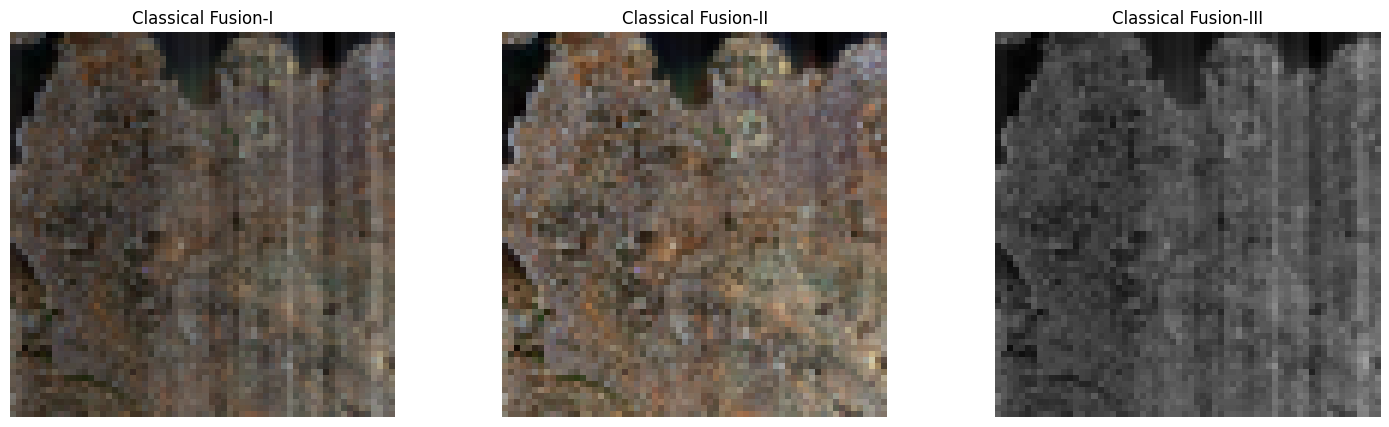

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(18,5))
#axs[0].imshow(rgb_img); axs[0].set_title("Original RGB")
axs[0].imshow(fused_m1_64); axs[0].set_title("Classical Fusion-I")
axs[1].imshow(fused_m2_64); axs[1].set_title("Classical Fusion-II")
axs[2].imshow(fused_m3_64); axs[2].set_title("Classical Fusion-III")
for ax in axs: ax.axis("off")
plt.show()


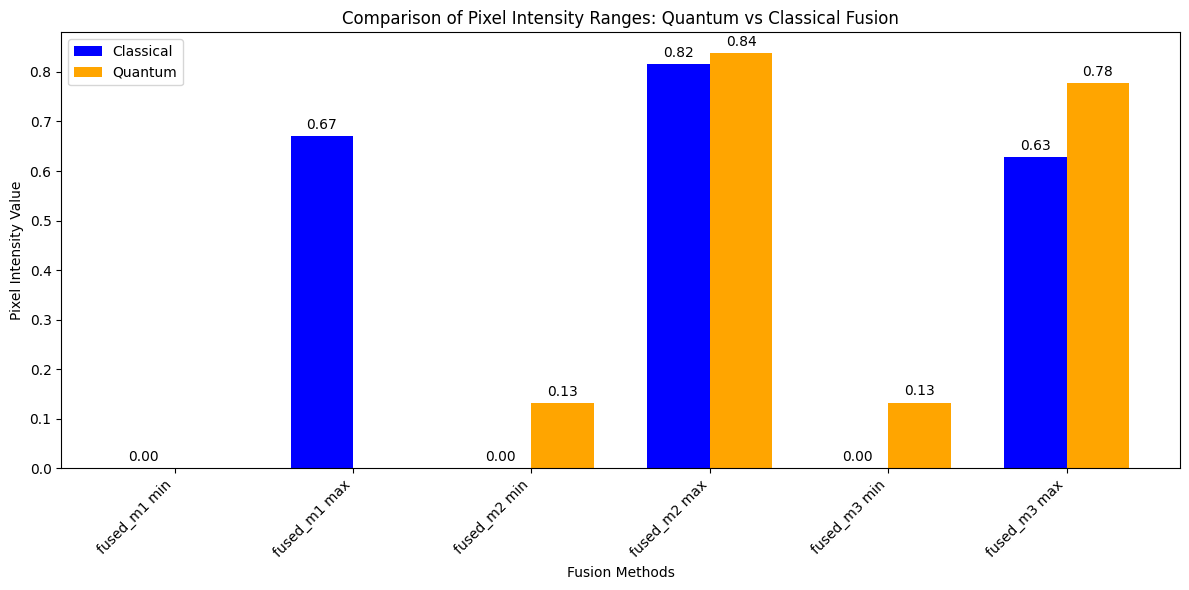

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Classical fusion values
classical_values = [
    fused_m1_64.min(), fused_m1_64.max(),
    fused_m2_64.min(), fused_m2_64.max(),
    fused_m3_64.min(), fused_m3_64.max()
]

# Quantum fusion values (only Method II & III)
quantum_values = [
    None, None,  # no quantum for Method I
    Quantum_fused_m2_64.min(), Quantum_fused_m2_64.max(),
    Quantum_fused_m3_64.min(), Quantum_fused_m3_64.max()
]

# Labels
labels = [
    "fused_m1 min", "fused_m1 max",
    "fused_m2 min", "fused_m2 max",
    "fused_m3 min", "fused_m3 max"
]

x = np.arange(len(labels))  # x positions
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Plot classical bars
rects1 = ax.bar(x - width/2, classical_values, width, label="Classical", color="blue")

# Plot quantum bars (skip None values)
quantum_values_clean = [v if v is not None else 0 for v in quantum_values]
rects2 = ax.bar(x + width/2, quantum_values_clean, width, label="Quantum", color="orange")

# Add labels & title
ax.set_ylabel("Pixel Intensity Value")
ax.set_title("Comparison of Pixel Intensity Ranges: Quantum vs Classical Fusion")
ax.set_xlabel("Fusion Methods")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Annotate bars
def autolabel(rects, values):
    for rect, v in zip(rects, values):
        if v is None:  # skip annotation for missing quantum
            continue
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, classical_values)
autolabel(rects2, quantum_values)

plt.tight_layout()
plt.show()
